<a href="https://colab.research.google.com/github/Satorumi/Machine-Learning/blob/main/R/Text_Analysis_wR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Analysis with R [Part 1]
- Text preparation and Visualization
- Sentiment Analysis
- Position tagging
- GloVe model for Embedding text

In [1]:
devtools::install_github("EmilHvitfeldt/sherlock")
library(sherlock)
packages <- c("textdata", "dplyr", "tidytext", "tidyverse", "wordcloud", "stringr", "ggpol",
            "scales", "ggplot2", "RColorBrewer", "ggpubr", "patchwork", "quanteda")
install.packages(packages, quiet = TRUE)
lapply(packages, require, character.only = TRUE)

Skipping install of 'sherlock' from a github remote, the SHA1 (38584034) has not changed since last install.
  Use `force = TRUE` to force installation

Loading required package: textdata

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidytext

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ stringr 1.4.0
✔ tidyr   1.1.3     ✔ forcats 0.5.1
✔ readr   2.0.1     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: wordc

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

In [2]:
discrete_palette <- "virdis"
sequential_palette <- "Blues"
diverging_palette <- "Spectral"
getPalette <- colorRampPalette(brewer.pal(8, "Set2"))

options(repr.plot.width = 11, repr.plot.height = 8)
theme_set(theme_minimal(base_size = 10))
theme_update(plot.title = element_text(size = 18, face = "bold"), plot.subtitle = element_text(size = 15, face = "italic"), 
          plot.caption = element_text(size = 12))

#### Dataset Context 
> Sherlock Holmes

In [3]:
dataset.original <- sherlock::holmes %>%
                  mutate(linenumber = row_number(),
                        part = cumsum(str_detect(text, regex("^PART"))),
                        chapter = cumsum(str_detect(text, regex("^CHAPTER")))) %>%
                  filter(!is.na(text) | text != "") %>%
                  ungroup()

head(dataset.original)

text,book,linenumber,part,chapter
<chr>,<chr>,<int>,<int>,<int>
A STUDY IN SCARLET,A Study In Scarlet,1,0,0
,A Study In Scarlet,2,0,0
Table of contents,A Study In Scarlet,3,0,0
,A Study In Scarlet,4,0,0
Part I,A Study In Scarlet,5,0,0
Mr. Sherlock Holmes,A Study In Scarlet,6,0,0


### Prepare data

Unnest sentences into seperate word token (e.g each row contain a single word)

> there are multiple methods to unnest tokens such as `ngrams`, which tokenizes by pairs of adjacent words rather than by individual ones. Allow us to see co-occurences and correlations of words

Remove stop words (e.g. “the”, “of”, “to”)

In [4]:
dataset.original %>% 
              unnest_tokens(word, text, token = "ngrams") %>%
              head(3)

book,linenumber,part,chapter,word
<chr>,<int>,<int>,<int>,<chr>
A Study In Scarlet,1,0,0,a study in
A Study In Scarlet,1,0,0,study in scarlet
A Study In Scarlet,2,0,0,NA


In [5]:
data(stop_words)

In [6]:
dataset.tidy <- dataset.original %>% 
              unnest_tokens(word, text, token = "words") %>% 
              anti_join(stop_words) %>%
              mutate(word = str_replace_all(str_trim(word, side = "both"), "[[:punct:]]", " "))

head(dataset.tidy)

Joining, by = "word"



book,linenumber,part,chapter,word
<chr>,<int>,<int>,<int>,<chr>
A Study In Scarlet,1,0,0,study
A Study In Scarlet,1,0,0,scarlet
A Study In Scarlet,3,0,0,table
A Study In Scarlet,3,0,0,contents
A Study In Scarlet,6,0,0,sherlock
A Study In Scarlet,6,0,0,holmes


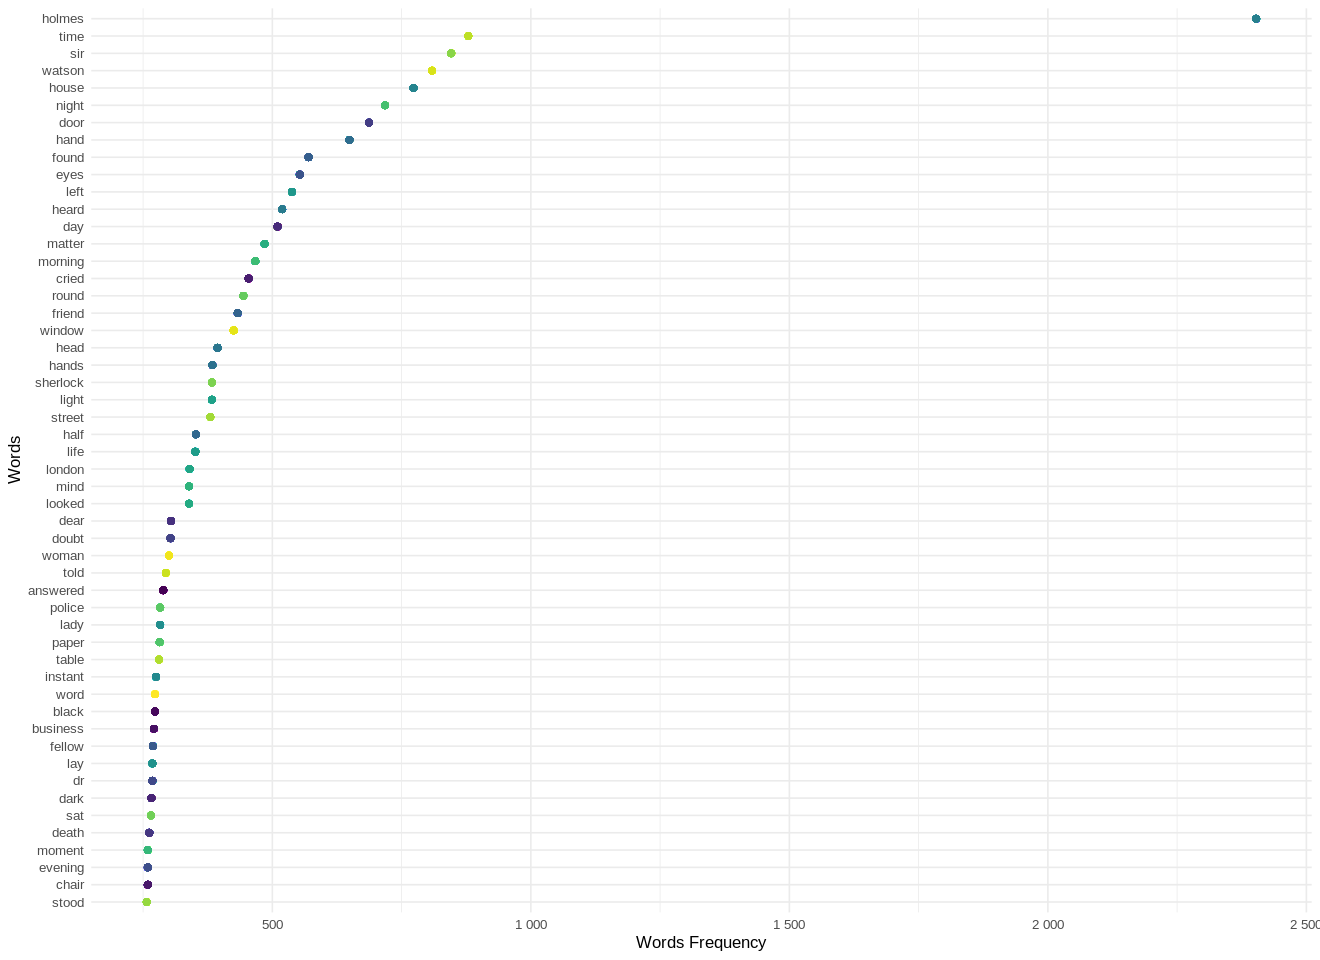

In [7]:
dataset.tidy %>% 
  add_count(word, sort = TRUE, name = "freq") %>%
  filter(freq > 250) %>% 
  ggplot(aes(freq,  reorder(word, freq), color = word)) + 
    geom_point() + 
    geom_segment(aes(xend = freq, yend = reorder(word, freq))) +
    scale_x_continuous(labels = number) + 
    scale_color_viridis_d(guide = "none") +
    labs(x = "Words Frequency", y = "Words")

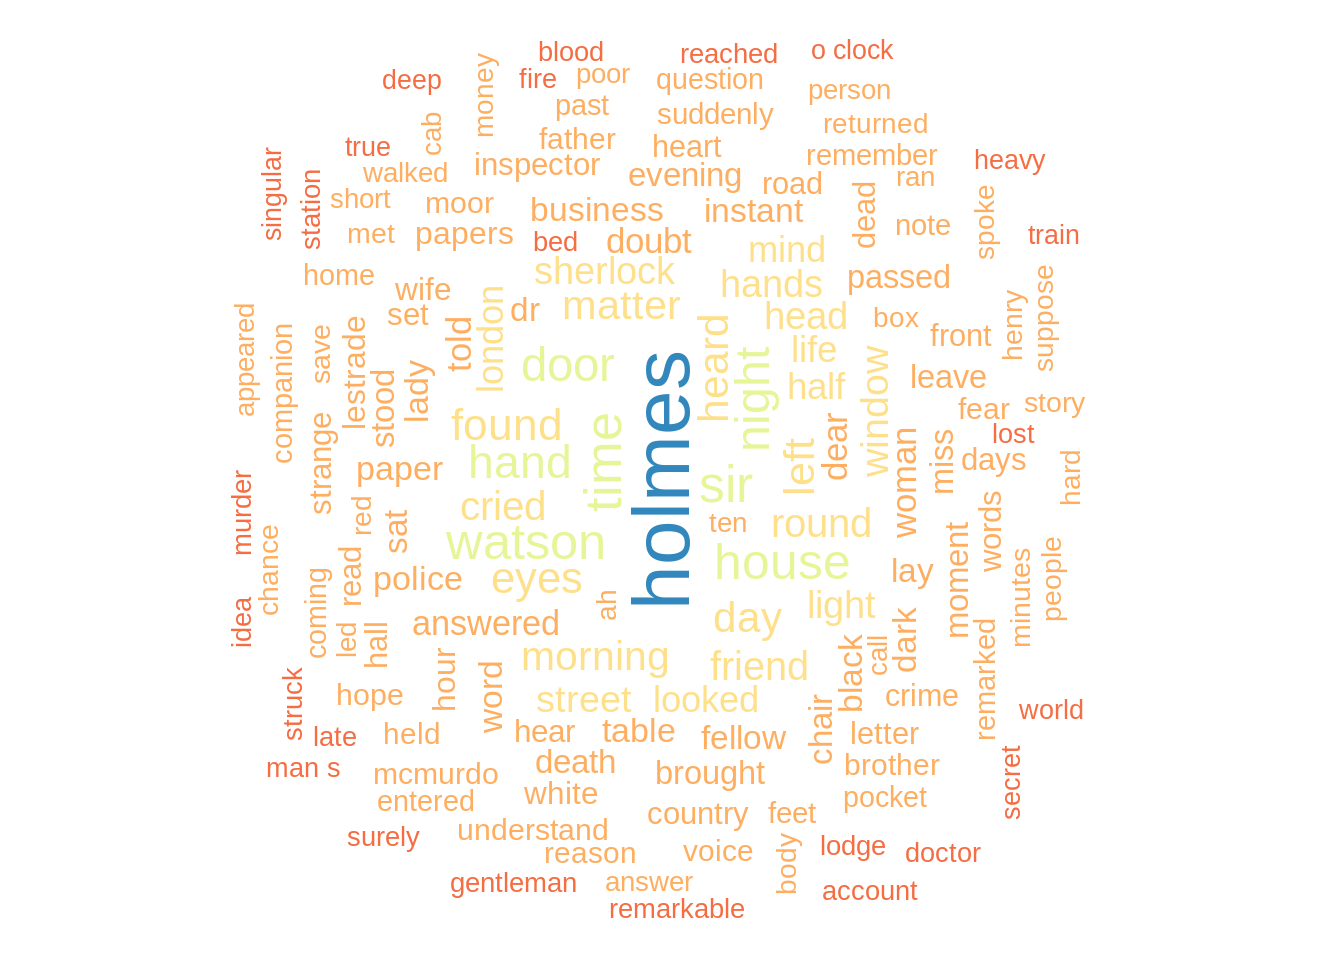

In [8]:
dataset.tidy %>%
  group_by(word) %>%
  dplyr::summarise(n = sqrt(n())) %>%
  with(wordcloud(word, n, max.words = 150, random.order = FALSE, 
              rot.per=0.35, colors = brewer.pal(8, diverging_palette)))

## Feature Engineering

### Sentiment Analysis

In [9]:
tns <- getNamespace("textdata")
assignInNamespace(x = "printer", value = function(...) 1, ns = tns)

nrc_joy <- get_sentiments("nrc") %>%
          filter(sentiment == "joy")

dataset.tidy %>% 
  inner_join(nrc_joy) %>%
  add_count(word) %>%
  head(5)

Joining, by = "word"



book,linenumber,part,chapter,word,sentiment,n
<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>
A Study In Scarlet,8,0,0,garden,joy,107
A Study In Scarlet,10,0,0,visitor,joy,90
A Study In Scarlet,42,1,1,found,joy,570
A Study In Scarlet,67,1,1,improve,joy,3
A Study In Scarlet,70,1,1,income,joy,12


To examine how sentiment changes throughout each novel. 
1. Count the sentiment frequency
2. Define index to track (lines of text)
> small sections of text may not be sufficient to determine the true sentiments while large set can wash out narrative structure.

4. use pivot_wider to seperate nagative & positive

#### Comparing the three sentiment dictionaries
> Three different lexicons: NRC, Bings, AFINN

AFINN lexicon classified sentiment in the range `-5 and 5`, while NRC and Bings classified words in to either `negative` or `positive`

In [10]:
n_lines <- 250

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"



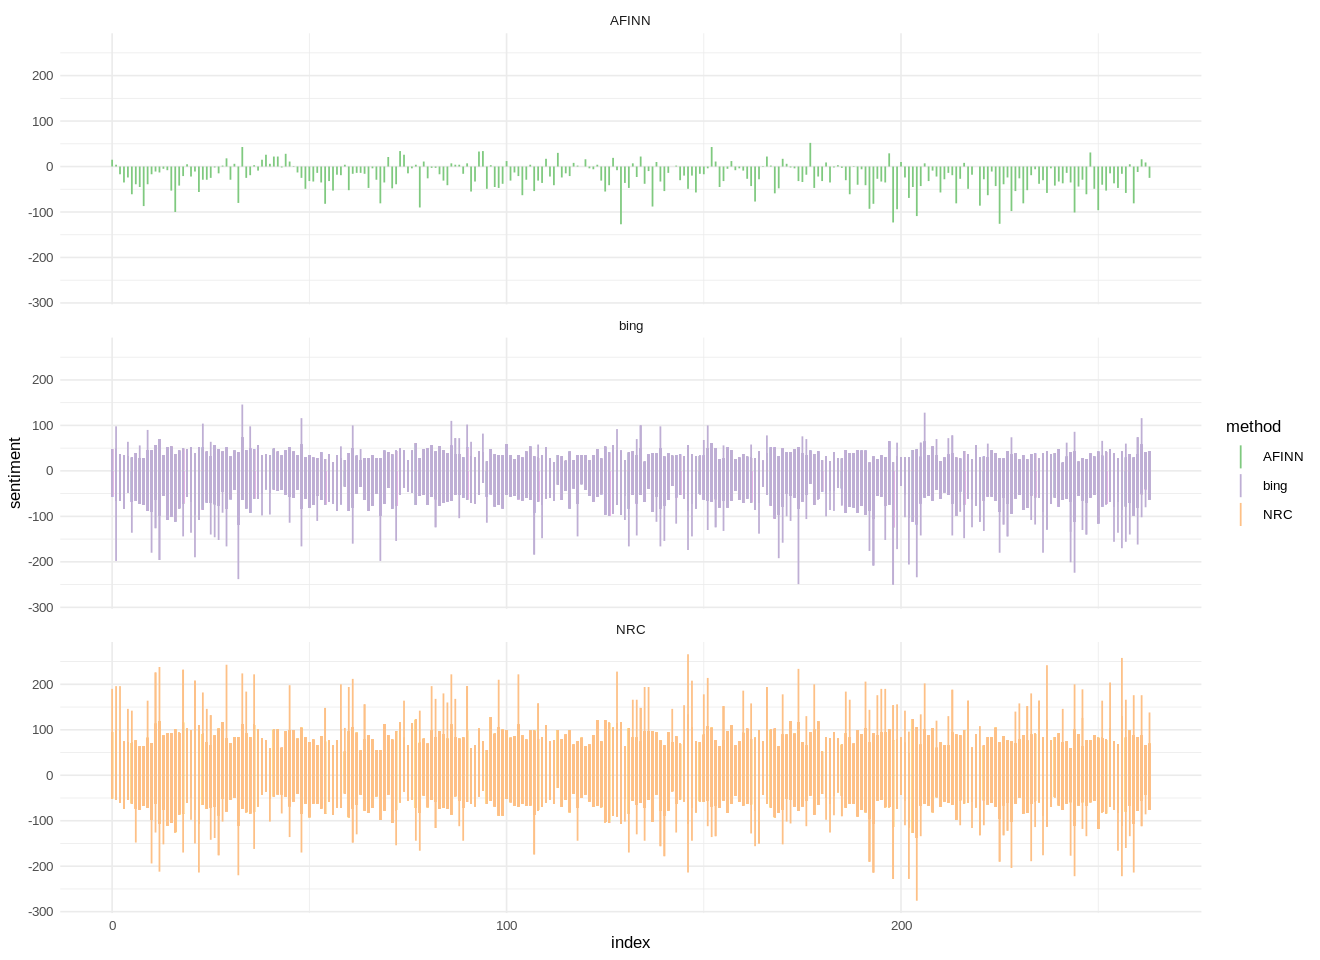

In [11]:
method.afinn <- dataset.tidy %>% 
                inner_join(get_sentiments("afinn")) %>%
                group_by(index = linenumber %/% n_lines) %>%
                dplyr::summarise(sentiment = sum(value)) %>% 
                mutate(method = "AFINN")


method.bing.nrc <- bind_rows(dataset.tidy %>% 
                  inner_join(get_sentiments("bing")) %>%
                  mutate(method = "bing"),
                  dataset.tidy %>% 
                  inner_join(get_sentiments("nrc")) %>%
                  mutate(method = "NRC") %>% 
                  filter(sentiment %in% c("negative", "positive"))
            ) %>%
            add_count(method, index = linenumber %/% n_lines, sentiment) %>%
            pivot_wider(names_from = sentiment, 
                        values_from = n, 
                        values_fill = 0, 
                        values_fn = sum) %>%
            mutate(sentiment = positive - negative) %>%
            select(c(index, sentiment, method))
                    
methods <- bind_rows(method.afinn, method.bing.nrc)

ggplot(methods, aes(index, sentiment, color = method)) + 
  geom_linerange(aes(ymin = 0, ymax = sentiment)) +
  scale_color_brewer(palette = "Accent") +
  facet_wrap(~method, ncol = 1)

In [12]:
create_table <- function(data, val, group, table_theme = "minimal") {
  stats <- c(group, "mean", "median", "sd", "max", "min")
  table <- desc_statby(data,  measure.var = val, grps = group)[, stats]
  table <- ggtexttable(table, cols = stats, rows = NULL, theme = ttheme(table_theme))
  return(table)
}

In [13]:
max_density <- function(obj) {
  density <- density(obj)
  max <- which.max(density$y)
  x <- density$x[max]
  y <- density$y[max]
  return(c(x, y))
}

Warning message:
“Ignoring unknown parameters: jitter.width”


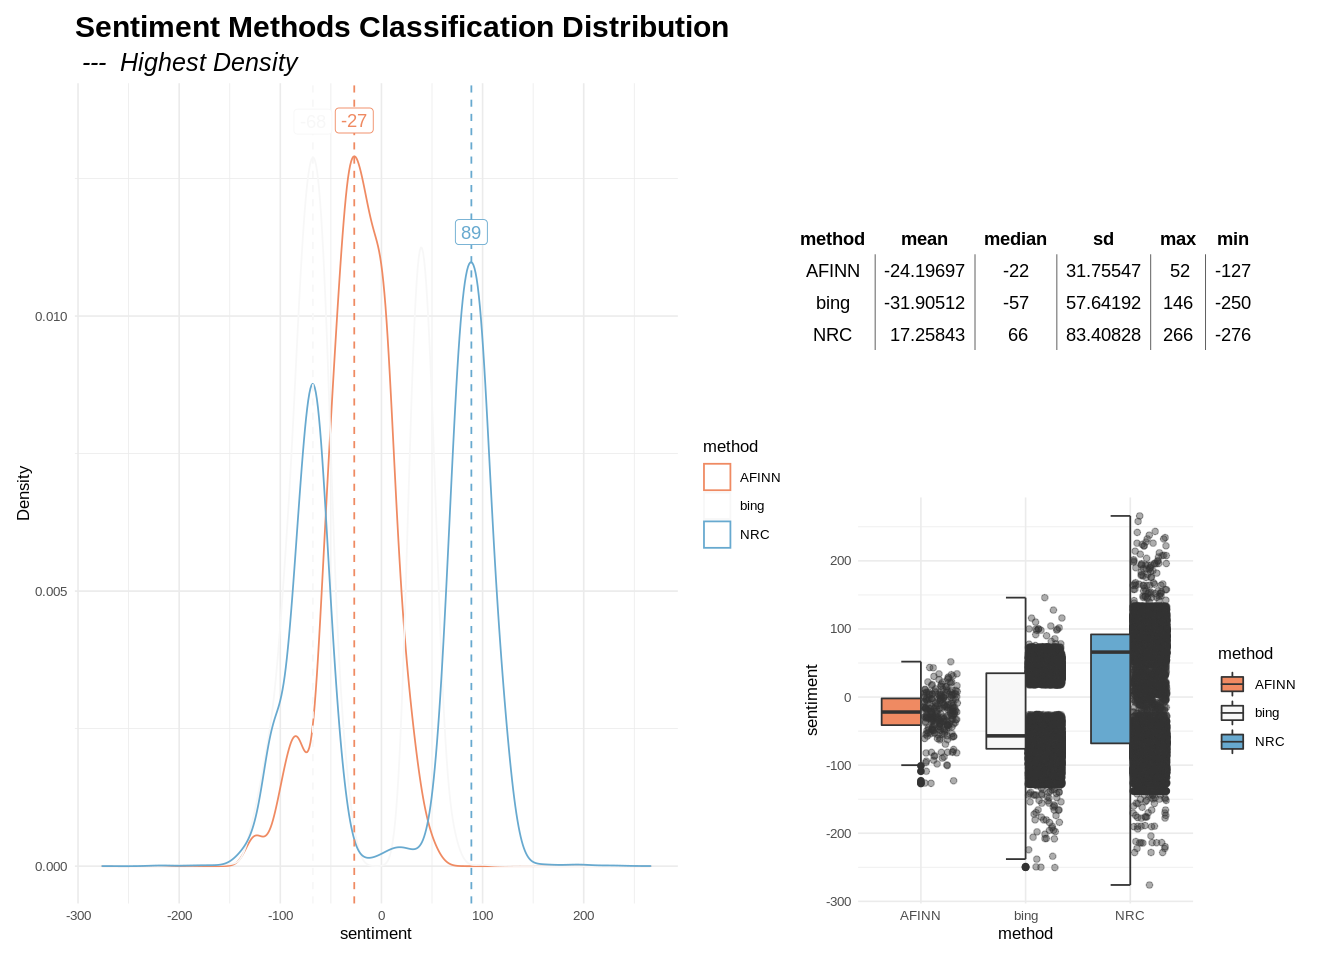

In [14]:
label_data <- methods %>% group_by(method) %>% 
            dplyr::summarise(x = max_density(sentiment)[1], 
                            y = max_density(sentiment)[2]) 

d <- ggplot(data = methods, aes(x = sentiment, color = method)) +
    geom_density(alpha = .4) + 
    geom_vline(data = label_data, aes(xintercept = x, color = method), linetype = "dashed", show.legend = FALSE) +
    geom_label(data = label_data, aes(x, y * 1.05, label = round(x), color = method), fill = "white", show.legend = FALSE) +
    scale_x_continuous(labels = number) +
    scale_color_brewer(palette = "RdBu") + 
    labs(title = "Sentiment Methods Classification Distribution", y = "Density", subtitle = " ---  Highest Density")

bp <- ggplot(methods, aes(x = method, y = sentiment, fill = method)) +
    geom_boxjitter(jitter.width = .001, jitter.alpha = .4, errorbar.draw = TRUE) +
    scale_fill_brewer(palette = "RdBu") +
    scale_y_continuous(labels = number)

t <- create_table(methods, "sentiment", "method")

(d | t / bp) + plot_layout(widths = c(0.9, 0.5))

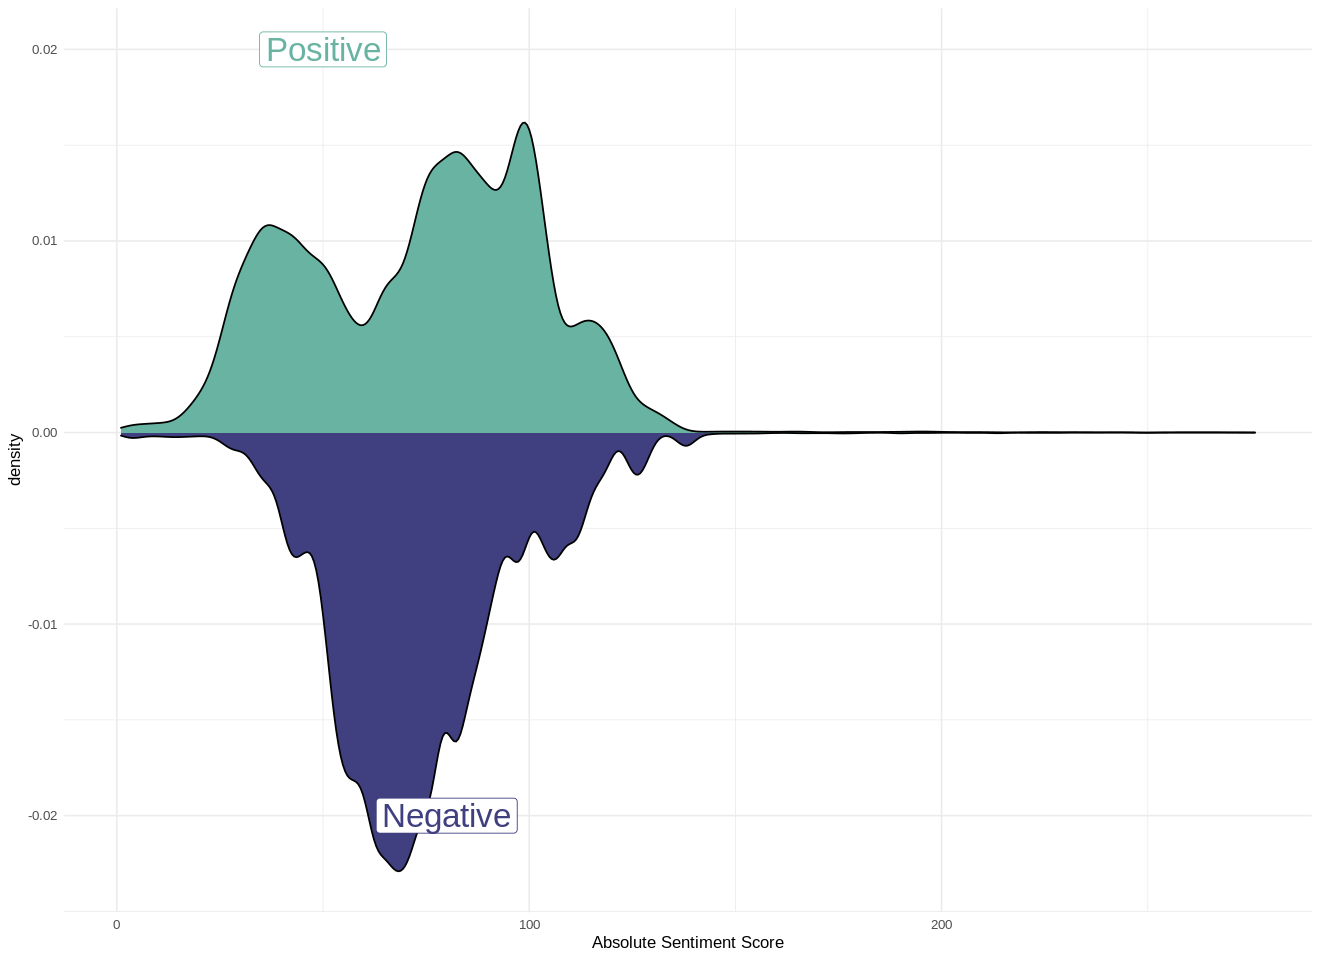

In [15]:
plot.pos <- methods$sentiment[methods$sentiment > 0]
plot.neg <- abs(methods$sentiment[methods$sentiment < 0])

ggplot(mpping = aes(x = x)) + 
  geom_density(aes(x = plot.pos, y = ..density..), fill= "#69b3a2") +
  geom_label(aes(x = 50, y = .02, label = "Positive"), color = "#69b3a2", size = 7) +
  geom_density(aes(plot.neg, y = -..density..), fill = "#404080") +
  geom_label(aes(x = 80, y = -.02, label = "Negative"), color = "#404080", size = 7) +
  labs(x = "Absolute Sentiment Score")

#### Suitable sentiment method

In [16]:
n_lines <- 150

dataset.sentiment <- dataset.tidy %>% 
            inner_join(get_sentiments("bing")) %>%
            add_count(word, sentiment, sort = TRUE) %>%
            mutate(n = ifelse(sentiment == "negative", sqrt(n)*-1, sqrt(n)))


Joining, by = "word"



`summarise()` has grouped output by 'word'. You can override using the `.groups` argument.



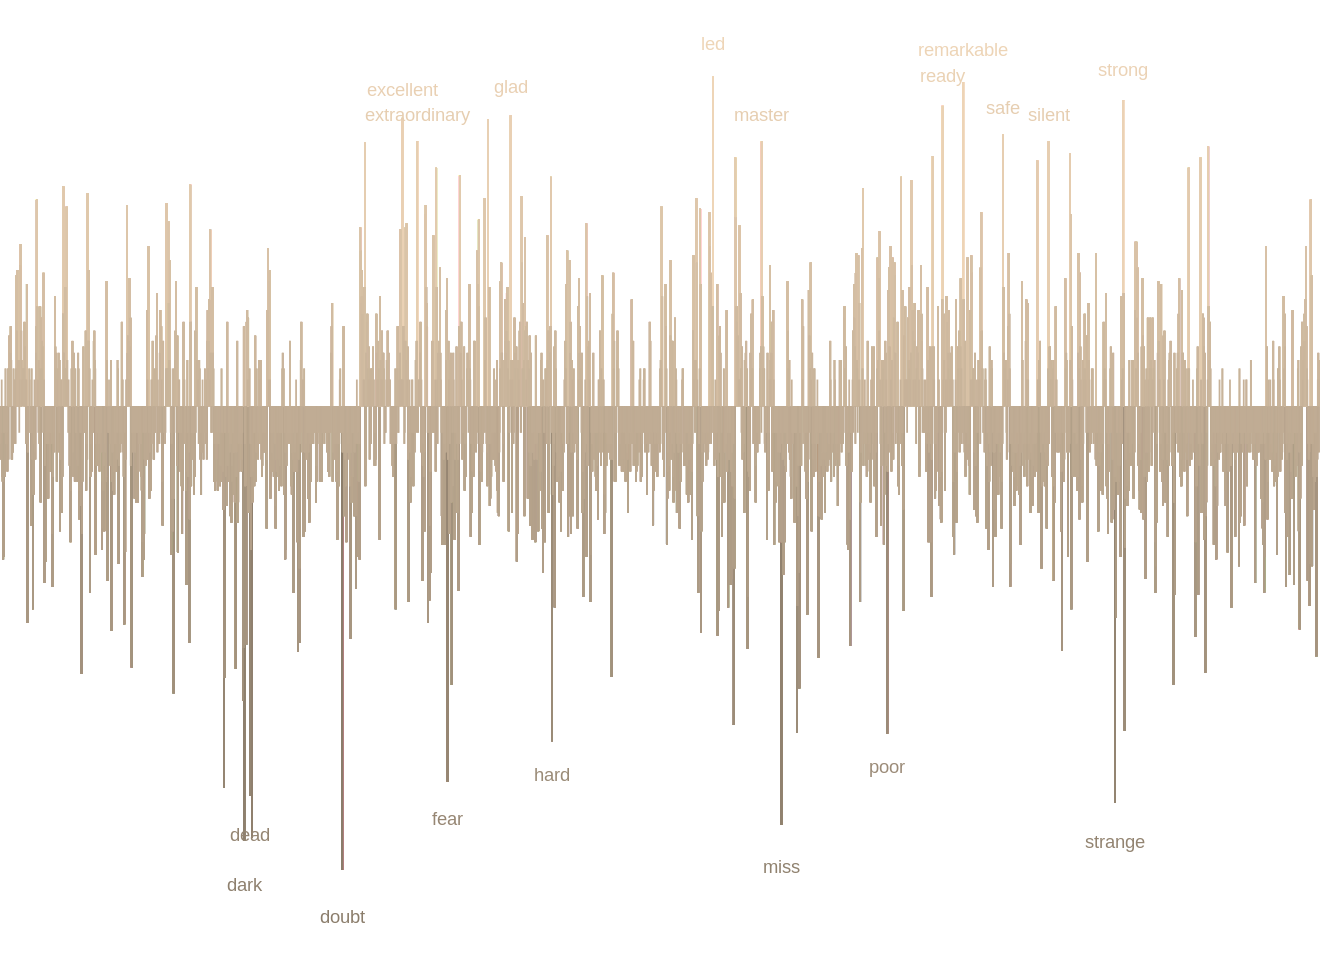

In [17]:
label.data <- dataset.sentiment %>% 
            group_by(word, sentiment) %>% 
            dplyr::summarise(n = mean(n)) %>% 
            group_by(sentiment) %>% 
            slice_max(abs(n), n = 10) 

ggplot(dataset.sentiment, aes(word, n, color = n)) +
  geom_linerange(aes(ymin = 0, ymax = n)) +
  scale_color_gradient(low = "bisque4", high = "bisque2", guide ="none") +
  geom_text(data = label.data, aes(x = word, y = n*1.1, label = word), check_overlap = TRUE) +
  labs(y = "Word Contribution") +
  theme(axis.text.x = element_blank()) +
  theme_void()

### POS - Part of Speech Labeling

In [18]:
data(parts_of_speech)

In [19]:
dataset.POS <- dataset.tidy %>%
            left_join(parts_of_speech) 
     
head(dataset.POS)

Joining, by = "word"



book,linenumber,part,chapter,word,pos
<chr>,<int>,<int>,<int>,<chr>,<chr>
A Study In Scarlet,1,0,0,study,Verb (usu participle)
A Study In Scarlet,1,0,0,study,Verb (transitive)
A Study In Scarlet,1,0,0,study,Verb (intransitive)
A Study In Scarlet,1,0,0,study,Noun
A Study In Scarlet,1,0,0,scarlet,NA
A Study In Scarlet,3,0,0,table,Noun


`summarise()` has grouped output by 'pos'. You can override using the `.groups` argument.



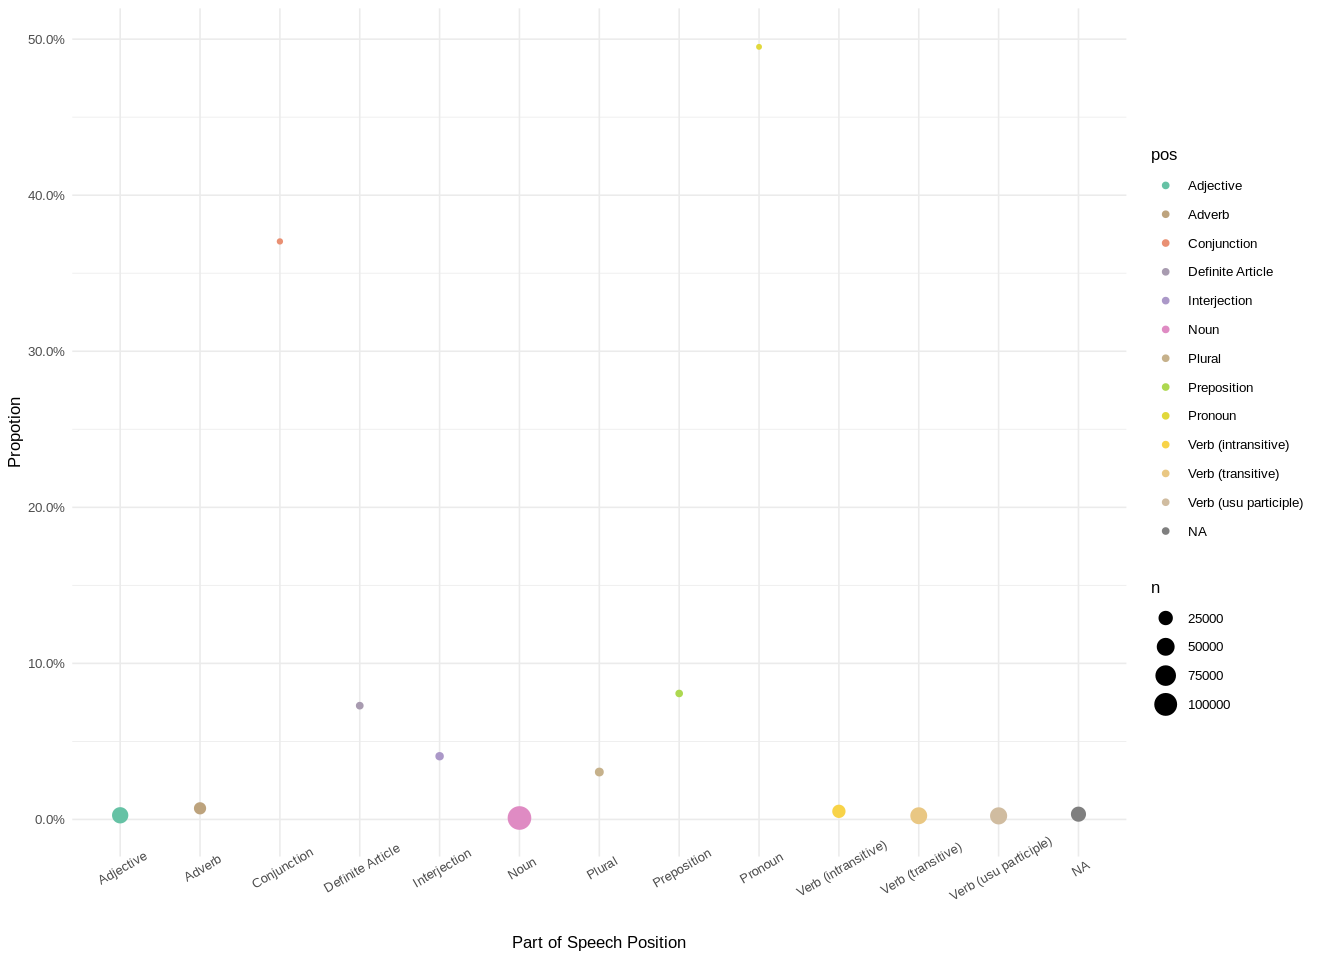

In [20]:
dataset.POS %>%
  add_count(pos) %>%
  group_by(pos) %>%
  summarise(prop = (n/sum(n)) * 100) %>%
  ungroup() %>%
  ggplot(aes(pos, prop, color = pos)) + 
  geom_count() +
  scale_y_continuous(labels = percent) +
  scale_color_manual(values = getPalette(length(unique(dataset.POS$pos)))) +
  theme(axis.text.x = element_text(angle = 30, vjust = 1)) +
  labs(x = "Part of Speech Position", y = "Propotion")

## Explore Data Analysis

### Analyzing word and document frequency: tf-idf

In [21]:
dataset.word <- dataset.tidy %>% 
              add_count(book, word, sort = T)

dataset.totalword <- dataset.word %>% group_by(book) %>% 
                  dplyr::summarise(total = sum(n))

dataset.word  <- left_join(dataset.word , dataset.totalword)

freq_by_book <- dataset.word %>% 
  group_by(book) %>%
  mutate(rank = row_number(), 
          prop = (n / total) * 100) %>%
  ungroup() 

Joining, by = "book"



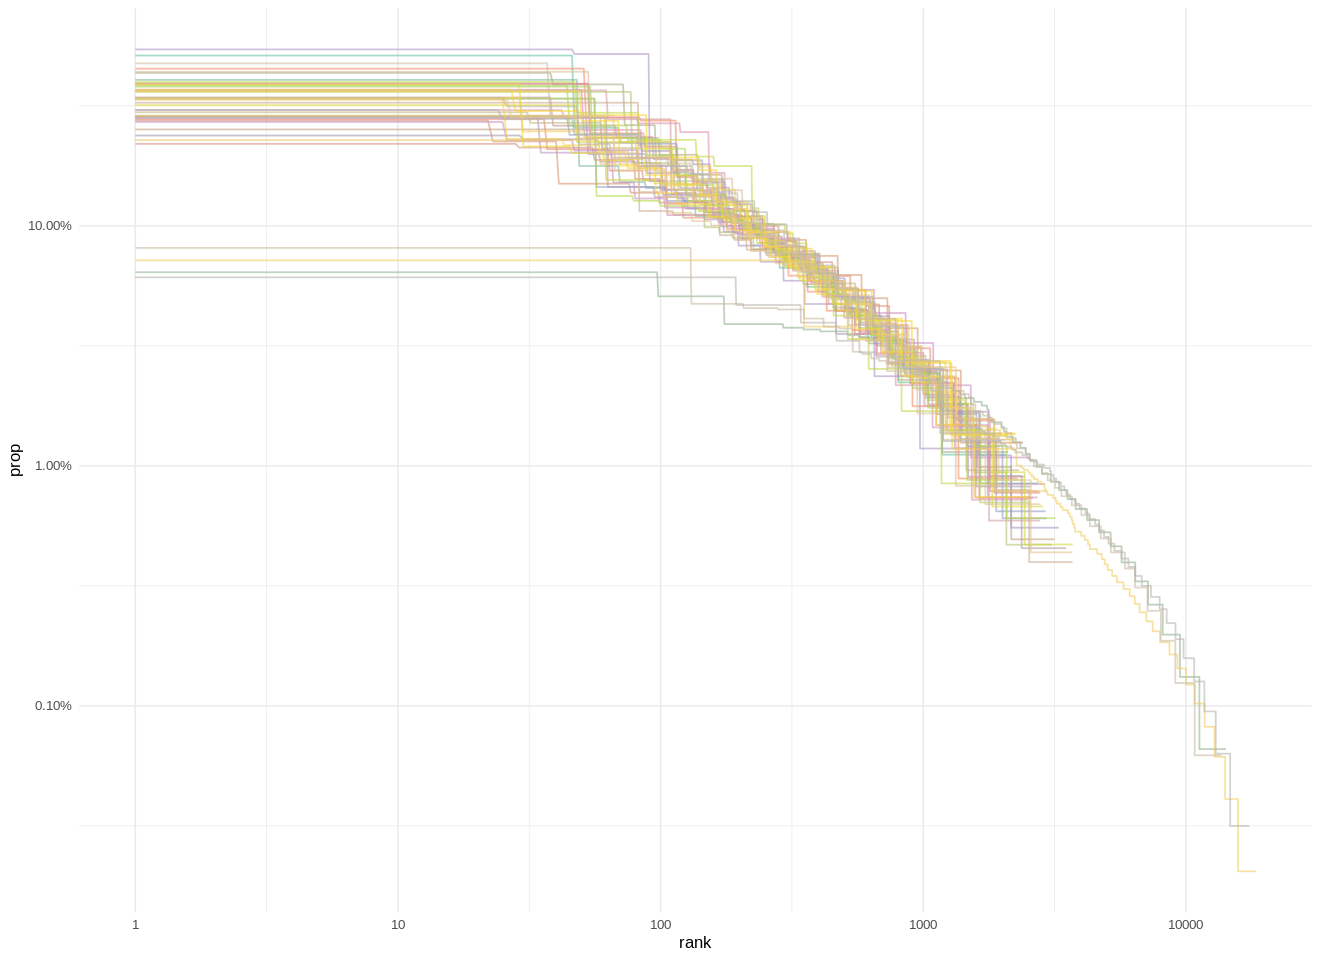

In [22]:
freq_by_book %>%
  ggplot(aes(rank, prop, color = book)) + 
  geom_line(size = .5, alpha = 0.6, show.legend = FALSE) +
  scale_x_log10() +
  scale_y_log10(labels = percent) +
  scale_color_manual(values = getPalette(length(unique(freq_by_book$book))))

Using tf-idf to find the important words for the content of each document by decreasing wieght of common words and increase wieght of uncommon words.
> `bind_tf_idf` take in: single `word` per row, document `book`, count `n`

In [25]:
dataset.tf_idf <- dataset.word %>% bind_tf_idf(word, book, n) 

dataset.tf_idf %>%
  select(-total) %>%
  group_by(book, word) %>%
  dplyr::summarise(tf_idf = mean(tf_idf)) %>%
  arrange(desc(tf_idf)) %>%
  head(5)

Warning message:
“A value for tf_idf is negative:
 Input should have exactly one row per document-term combination.”
`summarise()` has grouped output by 'book'. You can override using the `.groups` argument.



book,word,tf_idf
<chr>,<chr>,<dbl>
The Five Orange Pips,openshaw,0.002361887
The Stock-Broker's Clerk,mawson s,0.002320797
The Stock-Broker's Clerk,pycroft,0.002312595
The Resident Patient,trevelyan,0.002240563
The Musgrave Ritual,brunton,0.002209796


`summarise()` has grouped output by 'book'. You can override using the `.groups` argument.



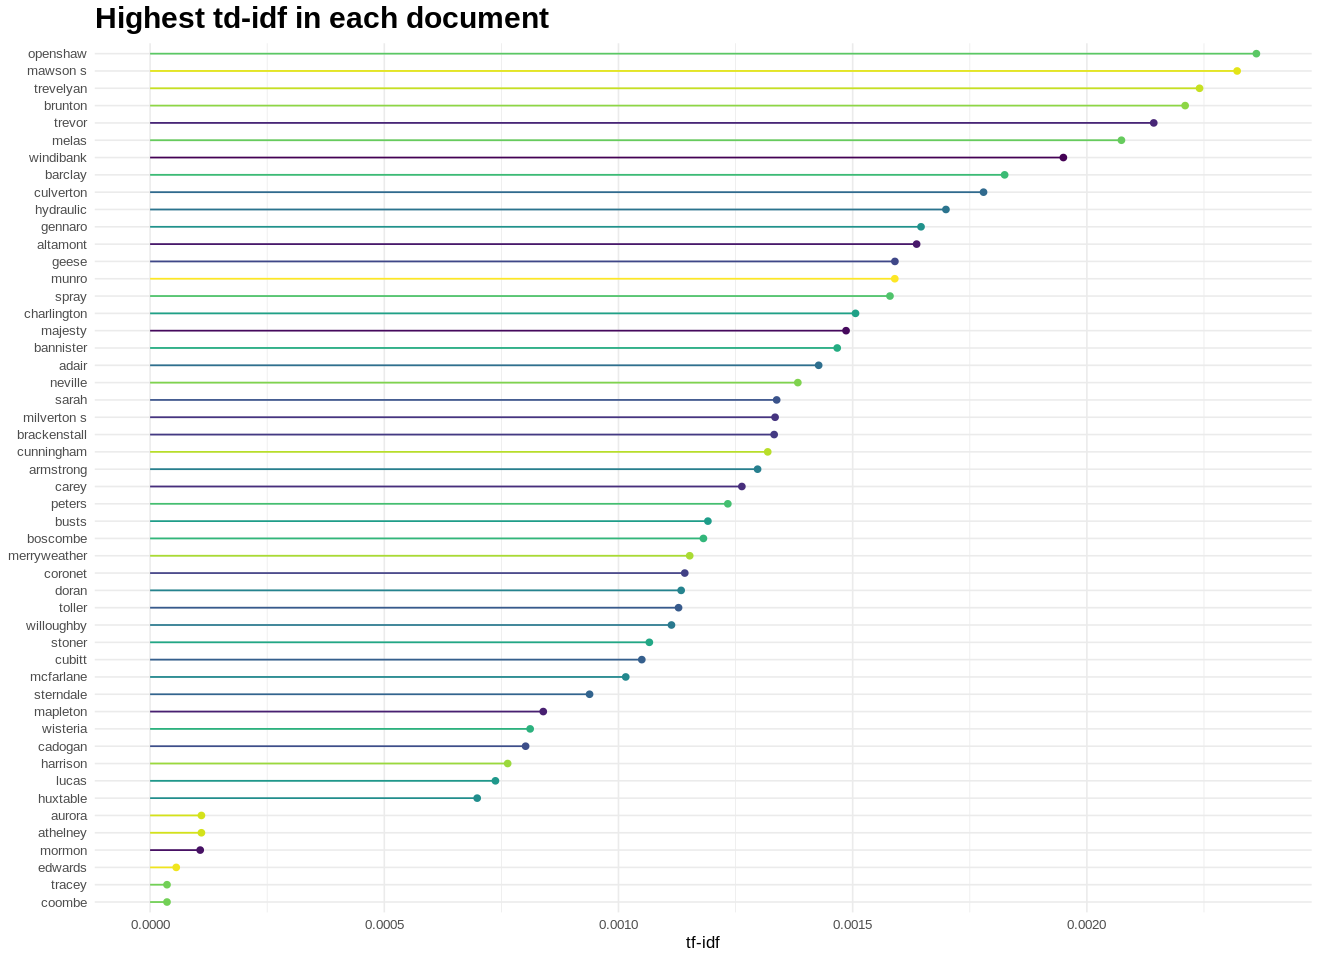

In [26]:
dataset.tf_idf %>%
  group_by(book, word) %>%
  dplyr::summarise(tf_idf = mean(tf_idf)) %>%
  slice_max(tf_idf, n = 1) %>%
  ungroup() %>%
  ggplot(aes(tf_idf, fct_reorder(word, tf_idf), color = book)) +
  geom_point() + 
  geom_segment(aes(xend = 0, yend = fct_reorder(word, tf_idf))) +
  scale_color_viridis_d(guide = "none") +
  labs(x = "tf-idf", y = NULL, title = "Highest td-idf word in each document")

## Topic Modelling

### GloVe

In [27]:
install.packages("text2vec", quiet = TRUE)
library(text2vec)

##### Create a vocab list

In [28]:
words <- list(dataset.tidy$word)
tokens <- itoken(words)
vocabs <- prune_vocabulary(create_vocabulary(tokens))

vocabs %>% head(3)

,term,term_count,doc_count
,<chr>,<int>,<int>
1,10 30,1,1
2,109,1,1
3,10th,1,1


##### token co-occurrence matrix (TCM)

In [29]:
vectorizer <- vocab_vectorizer(vocabs)
tcm <- create_tcm(tokens, vectorizer, skip_grams_window = 10)

##### create the word vectors based on the GloVe model

In [30]:
n_iters <- 20
glove = GlobalVectors$new(rank = 30, x_max = 10)
embedded <- glove$fit_transform(tcm, n_iter = n_iters, convergence_tol = 0.001)

dim(embedded)

INFO  [05:48:23.054] epoch 1, loss 0.0916 
INFO  [05:48:24.857] epoch 2, loss 0.0668 
INFO  [05:48:26.601] epoch 3, loss 0.0599 
INFO  [05:48:28.328] epoch 4, loss 0.0558 
INFO  [05:48:30.051] epoch 5, loss 0.0528 
INFO  [05:48:31.795] epoch 6, loss 0.0505 
INFO  [05:48:33.573] epoch 7, loss 0.0486 
INFO  [05:48:35.331] epoch 8, loss 0.0470 
INFO  [05:48:37.012] epoch 9, loss 0.0456 
INFO  [05:48:38.733] epoch 10, loss 0.0444 
INFO  [05:48:40.474] epoch 11, loss 0.0434 
INFO  [05:48:42.251] epoch 12, loss 0.0425 
INFO  [05:48:44.017] epoch 13, loss 0.0417 
INFO  [05:48:45.751] epoch 14, loss 0.0410 
INFO  [05:48:47.477] epoch 15, loss 0.0403 
INFO  [05:48:49.200] epoch 16, loss 0.0397 
INFO  [05:48:50.920] epoch 17, loss 0.0392 
INFO  [05:48:52.684] epoch 18, loss 0.0387 
INFO  [05:48:54.436] epoch 19, loss 0.0383 
INFO  [05:48:56.175] epoch 20, loss 0.0379 


[1] 17791    30

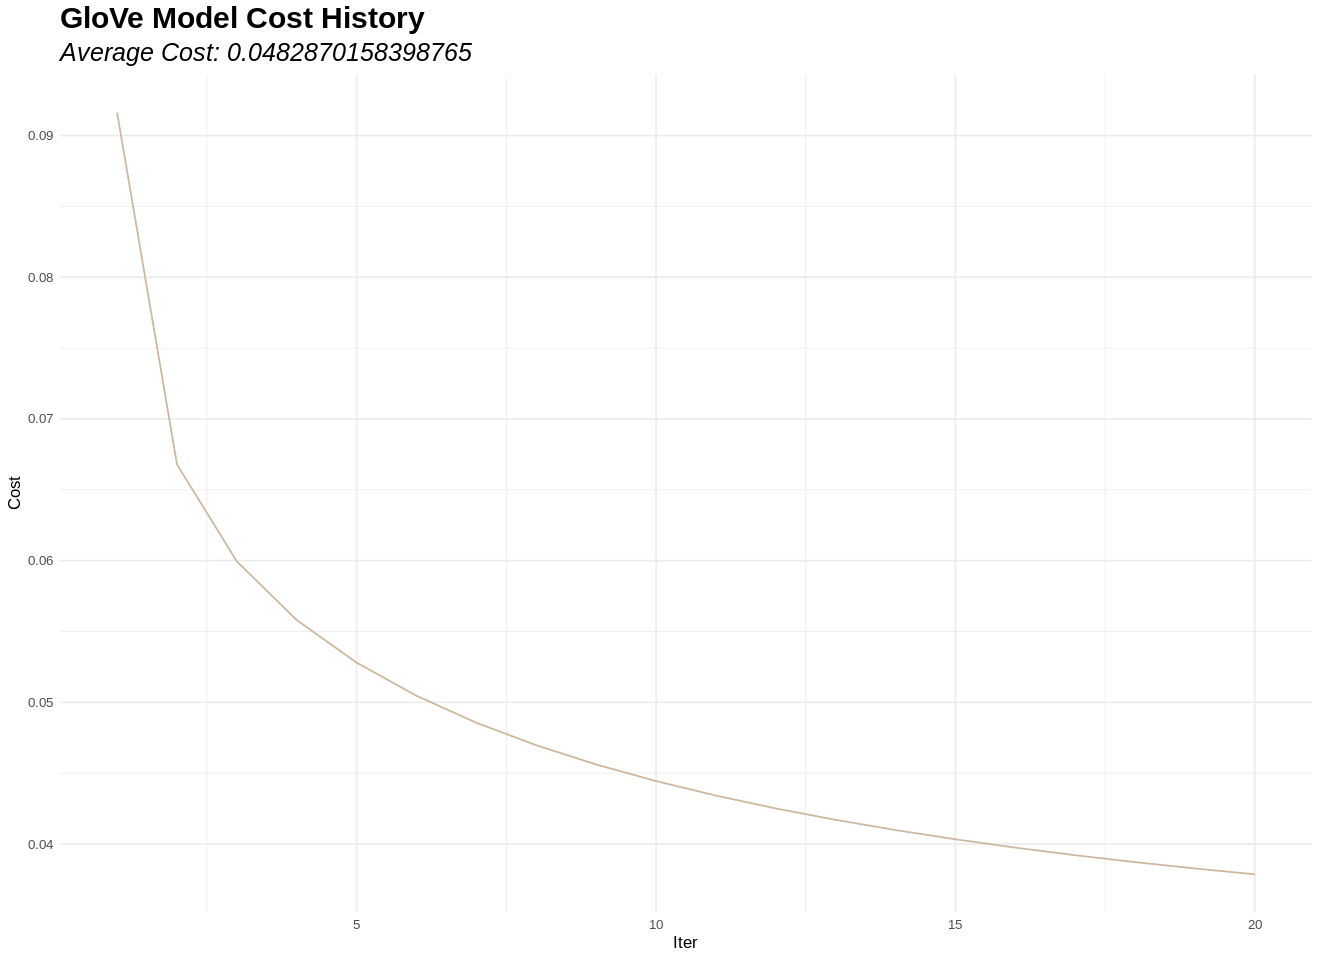

In [31]:
glove.history <- data.frame(glove$get_history(), iter = (1:n_iters))
ggplot(glove.history, aes(iter, cost_history)) + 
  geom_line(color = "bisque3") +
  labs(x = "Iter", y = "Cost", title = "GloVe Model Cost History", 
      subtitle = paste0("Average Cost: ", mean(glove.history$cost_history)))

In [32]:
word_context <- glove$components
word_vectors <- embedded + t(word_context)

head(word_vectors, 3)

10 30,-0.311659592,-0.002732082,0.04343328,0.14444590,-0.26936109,0.2111188,0.5796432,0.2312431,-0.3401701,0.27418834,⋯,-0.13646859,-0.2019190,-0.6126485,0.44175885,0.2845112,-0.4423286,1.023280,0.51685944,0.6958887,0.3136197
109,-0.087263743,0.751835258,0.06040635,-0.38981092,0.01603593,-0.5884106,-0.2766160,-0.1751536,0.5186010,-0.05143432,⋯,0.01350293,0.5679315,0.2749906,-0.08254802,0.1550680,0.1002465,0.938203,-0.07682784,0.2324189,0.3780988
10th,0.003954951,0.113547648,-0.83995526,-0.05440998,-0.04168884,0.7337873,0.4389812,-0.9942870,-0.7337323,0.23777862,⋯,0.02982264,0.5699905,0.6278494,-0.48920929,0.5528946,-0.4486269,1.215542,-0.68457014,-0.2583335,0.1705858


In [33]:
test <- word_vectors["watson", , drop = F] - 
      word_vectors["solve", , drop = F] +
      word_vectors["doctor", , drop = F] 

as.data.frame(sim2(x = word_vectors, y = test, method = "cosine", norm = "l2")) %>%
  rownames_to_column() %>%
  arrange(desc(watson)) %>%
  head(5)

,rowname,watson
,<chr>,<dbl>
1,watson,0.8934229
2,doctor,0.8522406
3,dear,0.8198612
4,glad,0.7951850
5,sherlock,0.7878683


#### UMAP - Uniform Manifold Approximation and Projection
> Perform Dimensionality Reduction & Projection

In [34]:
install.packages("umap")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [35]:
glove.umap <- umap::umap(word_vectors, n_components = 2, metric = "cosine", n_neighbors = 50)
head(glove.umap$layout, 3)

10 30,-1.0747631,0.3123634
109,-0.4409445,-1.4847427
10th,-0.3318375,1.1917708


In [36]:
umap_df <- as.data.frame(glove.umap$layout, stringsAsFactors = F)
umap_df$word <- rownames(word_vectors)
colnames(umap_df) <- c("component1", "component2", "word")
str(umap_df)

'data.frame':	17791 obs. of  3 variables:
 $ component1: num  -1.0748 -0.4409 -0.3318 0.6645 -0.0273 ...
 $ component2: num  0.312 -1.485 1.192 0.181 -1.172 ...
 $ word      : chr  "10 30" "109" "10th" "11 10" ...


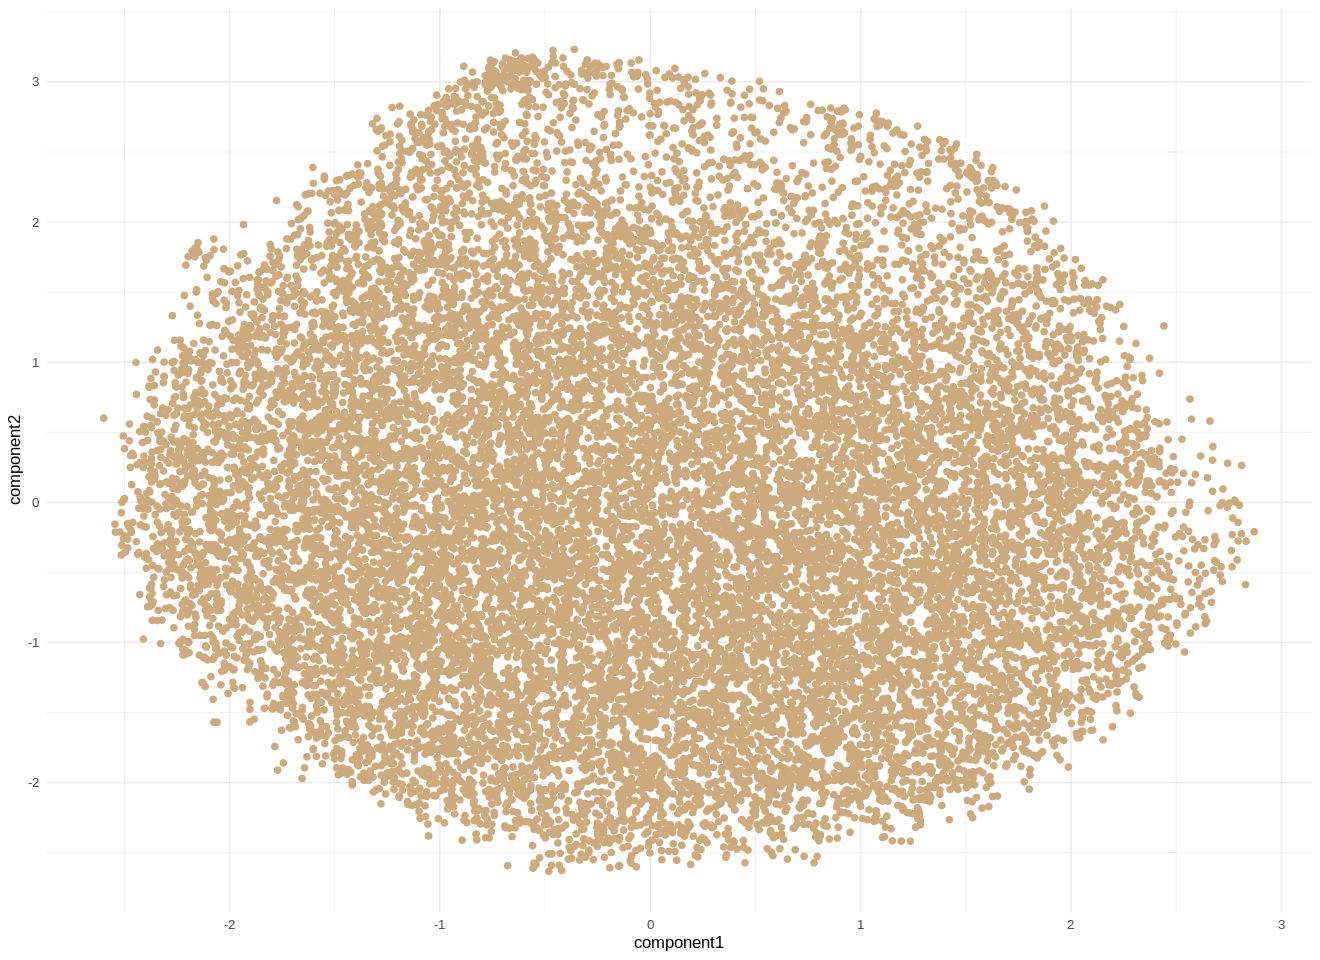

In [37]:
ggplot(umap_df, aes(component1, component2)) + 
  geom_point(color = "burlywood3")

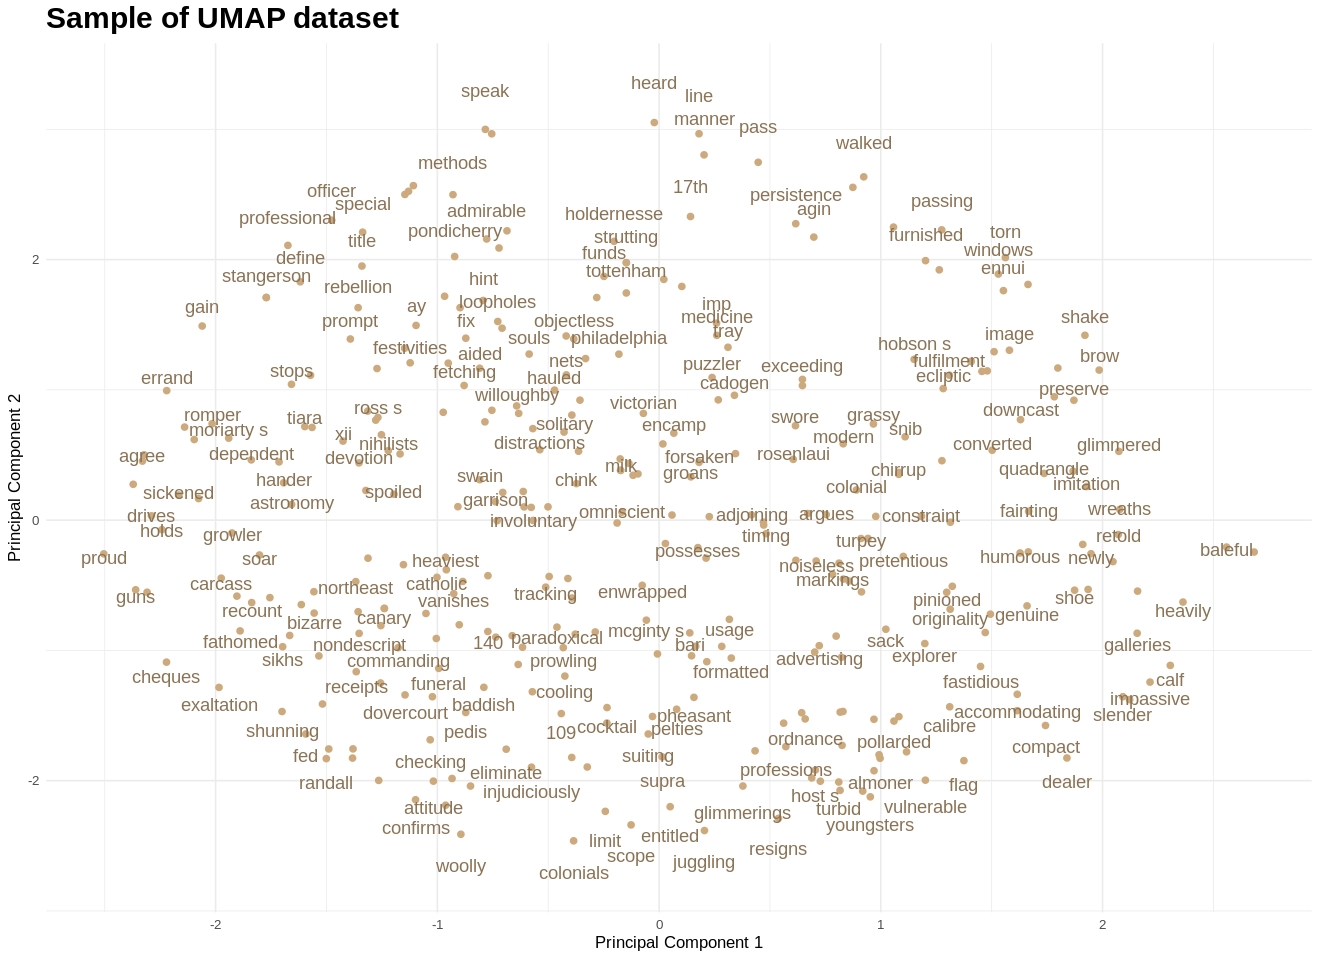

In [38]:
set.seed(42)
sample_size <- as.integer(nrow(umap_df) * .02)
sample_n(umap_df, sample_size, replace = T) %>%
  ggplot(aes(component1, component2, label = word)) +
  geom_point(color = "burlywood3") + 
  geom_text(aes(y = component2*1.1), check_overlap = T, color = "burlywood4") +
  labs(x = "Principal Component 1", y = "Principal Component 2", title = "Sample of UMAP dataset")

Joining, by = "word"



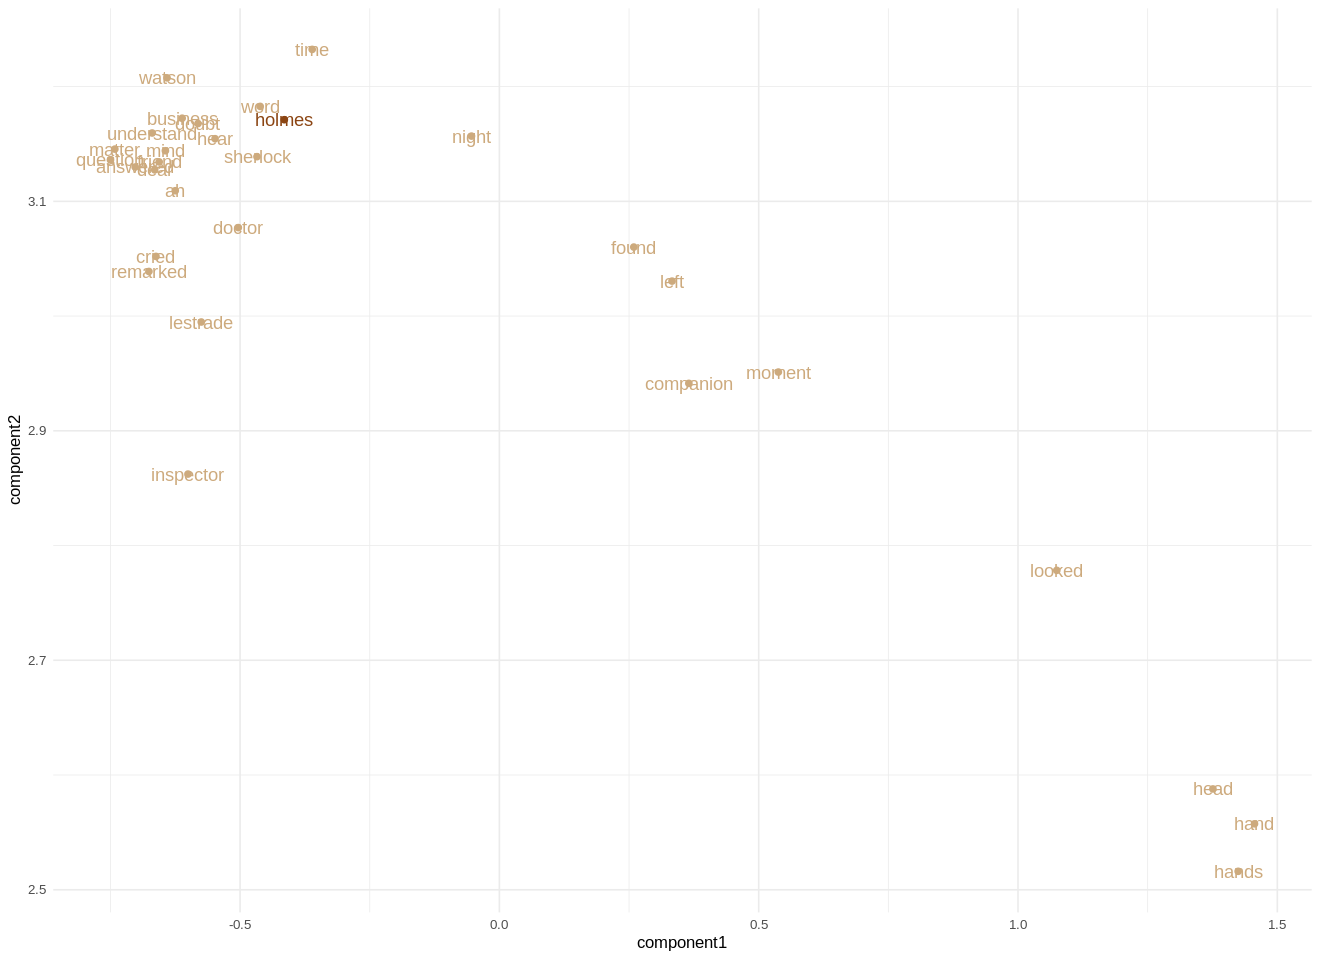

In [39]:
vector_ <- word_vectors["holmes", , drop = F]

data.frame(sim2(word_vectors, vector_, method = "cosine", norm = "l2")) %>%
  rownames_to_column() %>%
  setNames(., c("word", "vector_")) %>%
  slice_max(vector_, n = 30) %>%
  inner_join(umap_df, match = "all") %>%
  ggplot(aes(component1, component2, label = word, color = (word == "holmes"))) +
  geom_point() + geom_text() +
  scale_color_manual(values = c("burlywood3", "chocolate4"), guide = "none")

#### Join with the pre-prepared dataset on Position Tagging and Sentiment Analysis

In [40]:
join.sentiment <- dataset.sentiment %>% 
            group_by(word) %>%     
            slice(which.max(n)) %>%
            select(part, sentiment, word)

join.POS <- dataset.POS[!duplicated(dataset.POS$word), c("word", "pos")]

word_vectors.df <- as.data.frame(word_vectors) %>% 
                rownames_to_column(var = "word") %>%
                inner_join(join.sentiment) %>%
                inner_join(join.POS) %>%
                replace_na(list(pos = "Unknown"))

head(word_vectors.df)

Joining, by = "word"

Joining, by = "word"



,word,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V24,V25,V26,V27,V28,V29,V30,part,sentiment,pos
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,abomination,-0.31259290,0.63122221,0.5463278,0.1091895,0.14872781,0.94101021,0.58687740,0.6340739,0.5819057,⋯,-0.08179471,0.08394456,-0.3966601,0.32403598,0.83943984,0.2901331,0.36938198,2,negative,Noun
2,abound,-0.09948960,0.11276552,0.4532655,0.5723865,-0.25874174,0.30261713,-0.57013708,-0.9897655,0.2261599,⋯,-0.05654254,0.18580892,-0.3615268,-0.02938356,0.23308410,0.3067036,-0.02606591,2,positive,Verb (intransitive)
3,absentee,-0.44427696,-0.03201028,-0.2388175,0.3862107,-0.76724519,0.66832298,0.02880775,-0.1285980,-0.3269324,⋯,0.68082791,0.21336174,0.6337275,-0.08887810,-0.13108689,0.2112255,-0.94312713,2,negative,Noun
4,absurdity,0.49093799,0.60634264,0.6212507,0.6033560,0.08532426,0.08673383,0.05194762,0.6717803,-0.1821173,⋯,-0.42067818,-0.33507245,-0.6399002,-0.13823551,0.49298557,0.3125715,0.18836621,1,negative,Noun
5,abusive,-0.07759699,-0.96287422,0.3081584,-0.0508835,-0.26381811,-0.45087499,-0.76001772,0.1381695,0.4255395,⋯,0.32877243,-0.11878849,0.2338776,1.09338297,-0.03434296,0.3438782,0.20839566,2,negative,Adjective
6,acumen,-0.20270194,-0.21106870,-0.2757216,-0.7184533,-1.34301946,-0.35487735,-0.63311437,0.4786314,0.3865325,⋯,-0.21109354,-0.11926631,0.3575852,0.24622078,0.22461121,0.5059294,-0.45119894,2,positive,Noun


#### Save word_vectors as a csv.file

In [41]:
write.csv(x = word_vectors.df, file = "word_vectors.csv", row.names = FALSE)

### References

In [42]:
# https://github.com/EmilHvitfeldt/sherlock
# https://www.r-graph-gallery.com/density_mirror_ggplot2.html
# https://www.tidytextmining.com/sentiment.html
# https://www.r-bloggers.com/2020/02/a-guide-to-encoding-categorical-features-using-r/
# https://m-clark.github.io/text-analysis-with-R/shakespeare.html#scene-iii.-exploration
# https://medium.com/broadhorizon-cmotions/nlp-with-r-part-2-training-word-embedding-models-and-visualize-results-ae444043e234
# https://www.r-bloggers.com/2019/06/using-cosine-similarity-to-find-matching-documents-a-tutorial-using-senecas-letters-to-his-friend-lucilius/
# http://www.sthda.com/english/wiki/text-mining-and-word-cloud-fundamentals-in-r-5-simple-steps-you-should-know#step-3-text-mining